<a href="https://colab.research.google.com/github/ebudd45/Meteorologyclass/blob/main/millercomposite.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#Magic to make Cartopy work-takes a few minutes 
!pip install cartopy
!pip install -q condacolab
import condacolab
condacolab.install()
!mamba install -q -c conda-forge cartopy
import cartopy
cartopy.__version__

In [ ]:
#Install needed modules
!pip install metpy
!pip install cartopy
!pip install siphon
!pip install netcdf4

In [15]:
from datetime import datetime, timedelta

import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.lines as lines
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt
import metpy.calc as mpcalc
from metpy.plots import add_metpy_logo
import numpy as np
import numpy.ma as ma

from metpy.units import units
from netCDF4 import num2date
from scipy.ndimage import gaussian_filter
from siphon.catalog import TDSCatalog

In [5]:
# Specify our date/time of product desired
dt = datetime(2011, 4, 27, 12)

# Construct the URL for our THREDDS Data Server Catalog,
# and access our desired dataset within via NCSS
base_url = 'https://www.ncei.noaa.gov/thredds/model-namanl-old/'
cat = TDSCatalog(f'{base_url}{dt:%Y%m}/{dt:%Y%m%d}/catalog.xml')
ncss = cat.datasets[f'namanl_218_{dt:%Y%m%d}_{dt:%H}00_000.grb'].subset()

# Create our NCSS query with desired specifications
query = ncss.query()
query.all_times()
query.add_lonlat()
query.lonlat_box(-135, -60, 15, 65)
query.variables('Geopotential_height_isobaric',
                'u-component_of_wind_isobaric',
                'v-component_of_wind_isobaric',
                'Temperature_isobaric',
                'Relative_humidity_isobaric',
                'Best_4_layer_lifted_index_layer_between_two_pressure_'
                'difference_from_ground_layer',
                'Absolute_vorticity_isobaric',
                'Pressure_reduced_to_MSL_msl',
                'Dew_point_temperature_height_above_ground')

# Obtain the data we've queried for
data_18z = ncss.get_data(query)

# Assign variable names to collected data
dtime = data_18z.variables['Geopotential_height_isobaric'].dimensions[0]
dlev = data_18z.variables['Geopotential_height_isobaric'].dimensions[1]
lat = data_18z.variables['lat'][:]
lon = data_18z.variables['lon'][:]
lev = units.hPa * data_18z.variables[dlev][:]
times = data_18z.variables[dtime]
vtimes = num2date(times[:].squeeze(), times.units)
temps = data_18z.variables['Temperature_isobaric']
tmp = units.kelvin * temps[0, :]
uwnd = (units.meter / units.second) * data_18z.variables['u-component_of_wind_isobaric'][0, :]
vwnd = (units.meter / units.second) * data_18z.variables['v-component_of_wind_isobaric'][0, :]
hgt = units.meter * data_18z.variables['Geopotential_height_isobaric'][0, :]
relh = units.percent * data_18z.variables['Relative_humidity_isobaric'][0, :]
lifted_index = (data_18z.variables['Best_4_layer_lifted_index_layer_between_two_'
                                   'pressure_difference_from_ground_layer'][0, 0, :] *
                units(data_18z.variables['Best_4_layer_lifted_index_layer_between_two_'
                                         'pressure_difference_from_ground_layer'].units))
Td_sfc = (units(data_18z.variables['Dew_point_temperature_height_above_ground'].units) *
          data_18z.variables['Dew_point_temperature_height_above_ground'][0, 0, :])
avor = data_18z.variables['Absolute_vorticity_isobaric'][0, :] * units('1/s')
pmsl = (units(data_18z.variables['Pressure_reduced_to_MSL_msl'].units) *
        data_18z.variables['Pressure_reduced_to_MSL_msl'][0, :])

In [6]:
td = timedelta(hours=12)

ncss_06z = cat.datasets[f'namanl_218_{dt:%Y%m%d}_{dt-td:%H}00_000.grb'].subset()

query = ncss_06z.query()
query.all_times()
query.add_lonlat()
query.lonlat_box(-135, -60, 15, 65)
query.variables('Geopotential_height_isobaric',
                'Pressure_reduced_to_MSL_msl')

# Actually getting the data
data_06z = ncss_06z.get_data(query)

hgt_06z = units.meter * data_06z.variables['Geopotential_height_isobaric'][0, :]
pmsl_06z = (units(data_06z.variables['Pressure_reduced_to_MSL_msl'].units) *
            data_06z.variables['Pressure_reduced_to_MSL_msl'][0, :])

In [7]:
# 300 hPa, index 28
idx_300 = np.where(lev == 300. * units.hPa)[0][0]
u_300 = uwnd[idx_300, :].to('kt')
v_300 = vwnd[idx_300, :].to('kt')

# 500 hPa, index 20
idx_500 = np.where(lev == 500. * units.hPa)[0][0]
avor_500 = avor[1, ]
u_500 = uwnd[idx_500].to('kt')
v_500 = vwnd[idx_500].to('kt')
hgt_500 = hgt[idx_500]
hgt_500_06z = hgt_06z[idx_500]

# 700 hPa, index 12
idx_700 = np.where(lev == 700. * units.hPa)[0][0]
tmp_700 = tmp[idx_700].to('degC')
rh_700 = relh[idx_700]

# 850 hPa, index 6
idx_850 = np.where(lev == 850. * units.hPa)[0][0]
u_850 = uwnd[idx_850].to('kt')
v_850 = vwnd[idx_850].to('kt')

In [8]:
# 500 hPa CVA
dx, dy = mpcalc.lat_lon_grid_deltas(lon, lat)
vort_adv_500 = mpcalc.advection(avor_500, u_500.to('m/s'), v_500.to('m/s'),
                                dx=dx, dy=dy) 
vort_adv_500_smooth = gaussian_filter(vort_adv_500, 4)

In [9]:
wspd_300 = gaussian_filter(mpcalc.wind_speed(u_300, v_300), 5)
wspd_500 = gaussian_filter(mpcalc.wind_speed(u_500, v_500), 5)
wspd_850 = gaussian_filter(mpcalc.wind_speed(u_850, v_850), 5)

In [10]:
Td_dep_700 = tmp_700 - mpcalc.dewpoint_from_relative_humidity(tmp_700, rh_700)

/usr/local/lib/python3.9/site-packages/metpy/calc/thermo.py:1384: RuntimeWarning: divide by zero encountered in log
  val = np.log(vapor_pressure / mpconsts.nounit.sat_pressure_0c)


In [11]:
pmsl_change = pmsl - pmsl_06z
hgt_500_change = hgt_500 - hgt_500_06z

In [12]:
mask_500 = ma.masked_less_equal(wspd_500, 0.66 * np.max(wspd_500)).mask
u_500[mask_500] = np.nan
v_500[mask_500] = np.nan

# 300 hPa
mask_300 = ma.masked_less_equal(wspd_300, 0.66 * np.max(wspd_300)).mask
u_300[mask_300] = np.nan
v_300[mask_300] = np.nan

# 850 hPa
mask_850 = ma.masked_less_equal(wspd_850, 0.66 * np.max(wspd_850)).mask
u_850[mask_850] = np.nan
v_850[mask_850] = np.nan

In [13]:
# Set up our projection
crs = ccrs.LambertConformal(central_longitude=-100.0, central_latitude=45.0)

# Coordinates to limit map area
bounds = [-122., -75., 25., 50.]

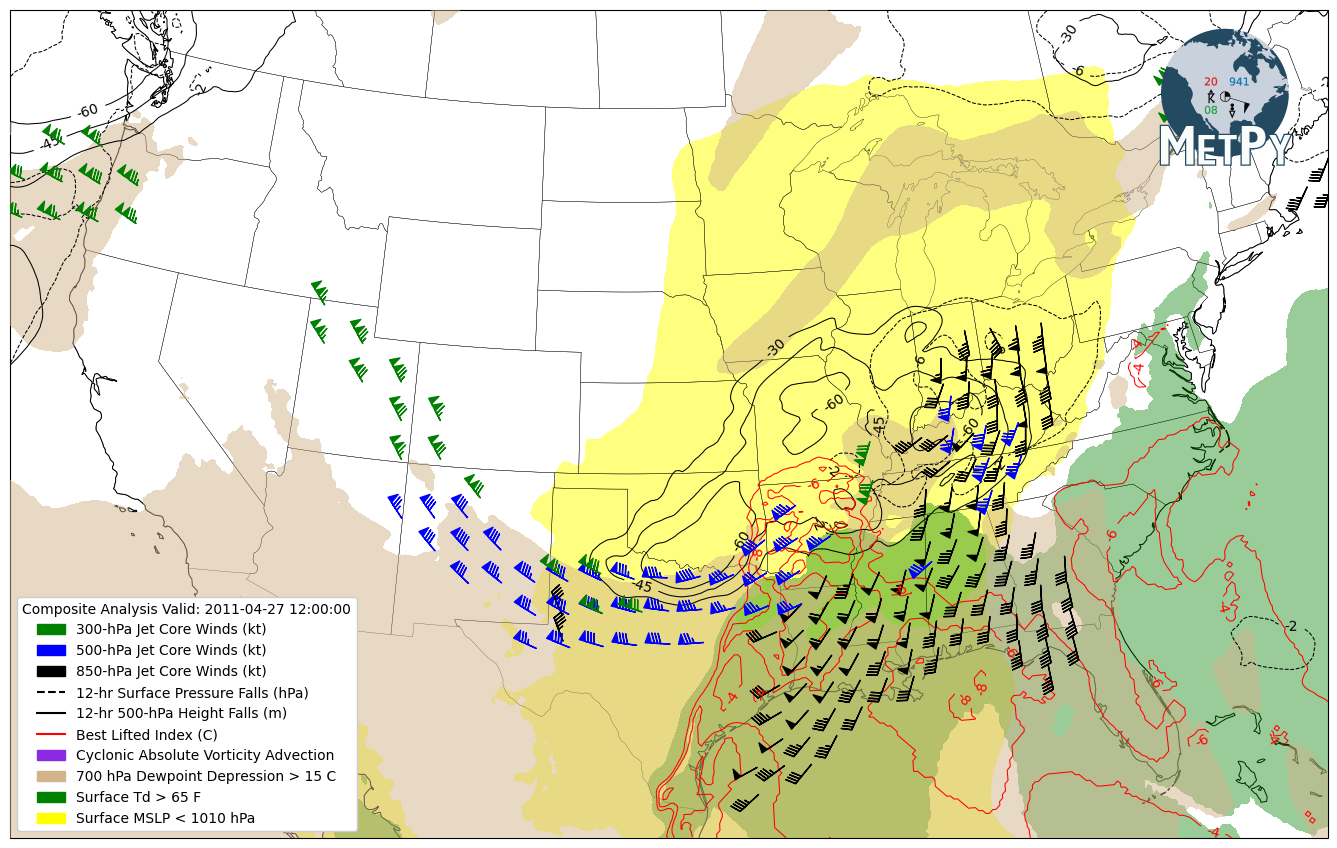

In [28]:
fig = plt.figure(1, figsize=(17, 12))
ax = fig.add_subplot(1, 1, 1, projection=crs)
ax.set_extent(bounds, crs=ccrs.PlateCarree())
ax.coastlines('50m', edgecolor='black', linewidth=0.75)
ax.add_feature(cfeature.STATES, linewidth=0.25)

# Plot Lifted Index
cs1 = ax.contour(lon, lat, lifted_index, range(-8, -2, 2), transform=ccrs.PlateCarree(),
                 colors='red', linewidths=0.75, linestyles='solid', zorder=7)
cs1.clabel(fontsize=10, inline=1, inline_spacing=7,
           fmt='%i', rightside_up=True, use_clabeltext=True)

# Plot Surface pressure falls
cs2 = ax.contour(lon, lat, pmsl_change.to('hPa'), range(-10, -1, 4),
                 transform=ccrs.PlateCarree(),
                 colors='k', linewidths=0.75, linestyles='dashed', zorder=6)
cs2.clabel(fontsize=10, inline=1, inline_spacing=7,
           fmt='%i', rightside_up=True, use_clabeltext=True)

# Plot 500-hPa height falls
cs3 = ax.contour(lon, lat, hgt_500_change, range(-60, -29, 15),
                 transform=ccrs.PlateCarree(), colors='k', linewidths=0.75,
                 linestyles='solid', zorder=5)
cs3.clabel(fontsize=10, inline=1, inline_spacing=7,
           fmt='%i', rightside_up=True, use_clabeltext=True)

# Plot surface pressure
ax.contourf(lon, lat, pmsl.to('hPa'), range(990, 1011, 20), alpha=0.5,
            transform=ccrs.PlateCarree(),
            colors='yellow', zorder=1)

# Plot surface dewpoint
ax.contourf(lon, lat, Td_sfc.to('degF'), range(65, 76, 10), alpha=0.4,
            transform=ccrs.PlateCarree(),
            colors=['green'], zorder=2)

# Plot 700-hPa dewpoint depression
ax.contourf(lon, lat, Td_dep_700, range(15, 46, 30), alpha=0.5, transform=ccrs.PlateCarree(),
            colors='tan', zorder=3)

# Plot Vorticity Advection
ax.contourf(lon, lat, vort_adv_500_smooth, range(5, 106, 100), alpha=0.5,
            transform=ccrs.PlateCarree(),
            colors='BlueViolet', zorder=4)

# Define a skip to reduce the barb point density
skip_300 = (slice(None, None, 12), slice(None, None, 12))
skip_500 = (slice(None, None, 10), slice(None, None, 10))
skip_850 = (slice(None, None, 8), slice(None, None, 8))

# 300-hPa wind barbs
jet300 = ax.barbs(lon[skip_300], lat[skip_300], u_300[skip_300].m, v_300[skip_300].m, length=6,
                  transform=ccrs.PlateCarree(),
                  color='green', zorder=10, label='300-hPa Jet Core Winds (kt)')


# 500-hPa wind barbs
jet500 = ax.barbs(lon[skip_500], lat[skip_500], u_500[skip_500].m, v_500[skip_500].m, length=6,
                  transform=ccrs.PlateCarree(),
                  color='blue', zorder=9, label='500-hPa Jet Core Winds (kt)')

# 850-hPa wind barbs
jet850 = ax.barbs(lon[skip_850], lat[skip_850], u_850[skip_850].m, v_850[skip_850].m, length=6,
                  transform=ccrs.PlateCarree(),
                  color='k', zorder=8, label='850-hPa Jet Core Winds (kt)')
# Add the MetPy logo!
fig = plt.gcf()
add_metpy_logo(fig, 1150, 675, size='large')

# Legend
purple = mpatches.Patch(color='BlueViolet', label='Cyclonic Absolute Vorticity Advection')
yellow = mpatches.Patch(color='yellow', label='Surface MSLP < 1010 hPa')
green = mpatches.Patch(color='green', label='Surface Td > 65 F')
tan = mpatches.Patch(color='tan', label='700 hPa Dewpoint Depression > 15 C')
red_line = lines.Line2D([], [], color='red', label='Best Lifted Index (C)')
dashed_black_line = lines.Line2D([], [], linestyle='dashed', color='k',
                                 label='12-hr Surface Pressure Falls (hPa)')
black_line = lines.Line2D([], [], linestyle='solid', color='k',
                          label='12-hr 500-hPa Height Falls (m)')
leg = plt.legend(handles=[jet300, jet500, jet850, dashed_black_line, black_line, red_line,
                          purple, tan, green, yellow], loc=3,
                 title=f'Composite Analysis Valid: {vtimes}',
                 framealpha=1)
leg.set_zorder(100)

